# Steel Challange Data Prep

In [ ]:
import torch
from torch import nn
from torchvision import models,transforms
from torch.utils.data import Dataset,DataLoader

from torchmetrics import IoU
import  torchmetrics
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm
import importlib
import nbimporter
from colordict import ColorDict
import random

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


torch.manual_seed(0)



import importlib
import nbimporter
import segmentation_utils_nb as utils
importlib.reload(utils)
## Custom Modules 

In [ ]:

import segmentation_utils_nb as utils
importlib.reload(utils)


### Clean Training Dataframe

In [ ]:
#Load Dataset
df = pd.read_csv('train_old.csv')


df = df.fillna(False)
df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
df['ClassId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
df= df.drop(['ImageId_ClassId'],1)
df = df[['ImageId','ClassId','EncodedPixels']].reset_index().drop(['index'],True)

df_pivot = df.pivot('ImageId','ClassId','EncodedPixels')
df_pivot_bool = df_pivot.astype(bool)
all_classes = list(set(df['ClassId']))

In [ ]:
transform = transforms.Compose(
        [transforms.Resize((256,1600)),
         transforms.ToTensor()
         ])
df_pivot = pd.read_csv('train_pivot.csv')

steelset = utils.SteelDataset(root_dir="train_images",df=df_pivot,nr_classes = 4,transform = transform)
dataloader = DataLoader(steelset,batch_size=12,shuffle='True')

In [ ]:
imgs,masks,label = iter(dataloader).next()

In [ ]:
_ = utils.img_mask_overlay(imgs,masks,figsize=4,alpha=0.2)

### How many Defect and non-Defect Images?

In [ ]:
df_defect_count = df_pivot_bool.any(axis=1).replace(True,'defect').replace(False,'no defect').value_counts()

sns.barplot(x=df_defect_count.index,y=df_defect_count.values)

### How many Occurences per Defect?

In [ ]:
df_defect_type_count = df_pivot_bool.sum(axis=0)

sns.barplot(x=df_defect_type_count.index,y=df_defect_type_count.values)
plt.title('Occurences per Defect')

### How many Defects per Image?

In [ ]:
df_pivot_num = df_pivot_bool.astype(int)
df_defects_per_image = df_pivot_num.sum(axis=1).value_counts()

sns.barplot(x=df_defects_per_image.index,y=df_defects_per_image.values)
plt.title('How many defects are present in an image')

### How much area do the Defects span relative to the Image size?

In [ ]:
#extract masks of all defects 
df_defect_only = df.drop(df[df['EncodedPixels']==False].index)
masks = {i:[] for i in '1234'}
for index,row in df_defect_only.iterrows():
    mask = utils.rle2mask(row['EncodedPixels'])
    mask_fraction = mask.sum()/(mask.shape[0]*mask.shape[1])
    masks[row['ClassId']].append(mask_fraction)



In [ ]:
#plot defect histograms
colordict = ColorDict()
plt.figure(figsize=(5,10), dpi=80)
#plt.subplots_adjust(hspace=5.000)
number_of_subplots=4

colorpalette = sns.color_palette()

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = plt.subplot(number_of_subplots,1,v)
    ax1.hist(masks[str(i+1)],density=True,bins = 100,label="Defect {}".format(str(i+1)),color=colorpalette[i])
    ax1.set_xlim([0,0.2])
    plt.legend()
plt.show()

### Defect 1 and Defect 2 are very small compared to defect 3 and 4 which can span large parts of the image

### Images of Defect 1

In [ ]:
df_class1 = df_pivot.loc[df_pivot["1"] != 'False']
steelset_class1 = utils.SteelDataset(root_dir="train_images",df=df_class1,nr_classes = 4,transform = transform)
dataloader_class1 = DataLoader(steelset_class1,batch_size=12,shuffle='True')

imgs_class1,masks_class1,labels = iter(dataloader_class1).next()



In [ ]:
def f(x):
    utils.img_mask_overlay(imgs_class1,masks_class1,figsize=4,alpha=x)

#interact(f,x=(0.0,1.0))
#plt.show()

f(0.5)

### Images of Defect 2

In [ ]:
df_class2 = df_pivot.loc[df_pivot["2"] != 'False']
steelset_class2 = utils.SteelDataset(root_dir="train_images",df=df_class2,nr_classes = 4,transform = transform)
dataloader_class2 = DataLoader(steelset_class2,batch_size=12,shuffle='True')

imgs_class2,masks_class2,labels = iter(dataloader_class2).next()


In [ ]:
def f(x):
    utils.img_mask_overlay(imgs_class2,masks_class2,figsize=4,alpha=x)

interact(f,x=(0.0,1.0))


### Images of Defect 3

In [ ]:
df_class3 = df_pivot.loc[df_pivot["3"] != 'False']
steelset_class3 = utils.SteelDataset(root_dir="train_images",df=df_class3,nr_classes = 4,transform = transform)
dataloader_class3 = DataLoader(steelset_class3,batch_size=12,shuffle='True')

imgs_class3,masks_class3,_ = iter(dataloader_class3).next()


In [ ]:
def f(x):
    utils.img_mask_overlay(imgs_class3,masks_class3,figsize=4,alpha=x)

interact(f,x=(0.0,1.0))

### Images of Defect 4

In [ ]:
df_class4 = df_pivot.loc[df_pivot["4"] != 'False']
steelset_class4 = utils.SteelDataset(root_dir="train_images",df=df_class4,nr_classes = 4,transform = transform)
dataloader_class4 = DataLoader(steelset_class4,batch_size=12,shuffle='True')

imgs_class4,masks_class4,_ = iter(dataloader_class4).next()


In [ ]:
def f(x):
    utils.img_mask_overlay(imgs_class4,masks_class4,figsize=4,alpha=x)

interact(f,x=(0.0,1.0))

### Ensure that Data can be Split reliably in Training and Validation Set

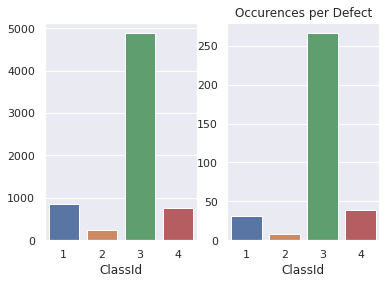

In [38]:
from sklearn.model_selection import train_test_split

df_train,df_val = train_test_split(df_pivot_bool,train_size=0.95,test_size=0.05)

df_train_defect_type_count = df_train.sum(axis=0)

df_val_defect_type_count = df_val.sum(axis=0)

dfs = [df_train_defect_type_count,df_val_defect_type_count]

fig,axs = plt.subplots(1,2,squeeze=False)

for idx,df in enumerate(dfs):
    sns.barplot(x=df.index,y=df.values,ax=axs[0][idx])
    plt.title('Occurences per Defect')

/home/kil/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kil/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kil/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


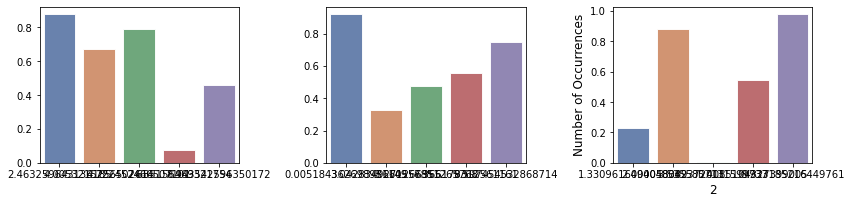

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nr_rows = 1
nr_cols = 3

cols_review = ['home_ownership', 'verification_status', 'loan_status']

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)

for r in range(0,nr_rows):
    for c in range(0, nr_cols):  
        col = r*nr_cols+c
        if col < len(cols_review):
            x=np.random.rand(5) * 10
            y=np.random.rand(5)
            sns.set(style="darkgrid")
            sns.barplot(x, y, alpha=0.9,ax = axs[r][c])
            plt.ylabel('Number of Occurrences', fontsize=12)
            plt.xlabel(col, fontsize=12)
plt.tight_layout()    
plt.show()